In [ ]:
import numpy as np
import pandas as pd
import tqdm
import os
import re
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
print("Current working directory:", os.getcwd())

current_directory = os.getcwd()
meta_data = os.path.join(current_directory, "combined_meta.csv")
raw_data = os.path.join(current_directory, "combined_raw.csv")
replicate_data = os.path.join(current_directory, "combined_replicate.csv")

# Read CSV files into DataFrames
meta_df = pd.read_csv(meta_data)
raw_df = pd.read_csv(raw_data)
replicate_df = pd.read_csv(replicate_data)

# Print some info to check if everything's loaded properly
print("Meta DataFrame shape:", meta_df.shape)
print("Raw DataFrame shape:", raw_df.shape)

print("First few rows of meta_df:\n", meta_df.head())
print("First few rows of raw_df:\n", raw_df.head())
print("First few rows of replicate_df:\n", replicate_df.head())



Current working directory: /users/7/hamza050
Meta DataFrame shape: (9247, 9)
Raw DataFrame shape: (9247, 66)
First few rows of meta_df:
   well content  replicate     content_replicate  format      plate_ID  \
0  A01   blank          1  blank_1-20230920_M10      96  20230920_M10   
1  A03     43G          1                 43G_1      96  20230920_M10   
2  A04  43Gx01          1              43Gx01_1      96  20230920_M10   
3  A05     44G          1                 44G_1      96  20230920_M10   
4  A06  44Gx01          1              44Gx01_1      96  20230920_M10   

  instrument phase  final  
0        M10     G      0  
1        M10     G      0  
2        M10     G      0  
3        M10     G      0  
4        M10     G      0  
First few rows of raw_df:
       content_replicate   X0  X0.75  X1.5  X2.25   X3  X3.75  X4.5  X5.25  \
0  blank_1-20230920_M10  626    331   347    357  368    381   396    384   
1                 43G_1  484    282   289    297  294    292   289    289  

In [ ]:
# ======================
# DATA CLEANING STEP 1: REMOVING 'blank'
# ======================

print("Initial DataFrame shapes before cleaning:")
print("Meta DataFrame shape:", meta_df.shape)
print("Raw DataFrame shape:", raw_df.shape)


# Get initial row counts
initial_raw_rows = raw_df.shape[0]
initial_meta_rows = meta_df.shape[0]

# Remove rows where 'content_replicate' contains 'blank' (case-insensitive)
raw_df = raw_df[~raw_df['content_replicate'].str.contains('blank', case=False, na=False)]
meta_df = meta_df[~meta_df['content_replicate'].str.contains('blank', case=False, na=False)]

# Calculate rows removed
raw_rows_removed = initial_raw_rows - raw_df.shape[0]
meta_rows_removed = initial_meta_rows - meta_df.shape[0]

# Print results
print(f"Step 1: Removed {raw_rows_removed} rows from raw_df containing 'blank'")
print(f"Step 1: Removed {meta_rows_removed} rows from meta_df containing 'blank'")

# ======================
# DATA CLEANING STEP 2: REMOVING 'KBC'
# ======================

# Get row counts after Step 1
step1_raw_rows = raw_df.shape[0]
step1_meta_rows = meta_df.shape[0]

# Remove rows where 'content_replicate' contains 'KBC' (case-insensitive)
raw_df = raw_df[~raw_df['content_replicate'].str.contains('KBC', case=False, na=False)]
meta_df = meta_df[~meta_df['content_replicate'].str.contains('KBC', case=False, na=False)]

# Calculate rows removed in this step
raw_rows_removed_kbc = step1_raw_rows - raw_df.shape[0]
meta_rows_removed_kbc = step1_meta_rows - meta_df.shape[0]

# Print results
print(f"\nStep 2: Removed {raw_rows_removed_kbc} rows from raw_df containing 'KBC'")
print(f"Step 2: Removed {meta_rows_removed_kbc} rows from meta_df containing 'KBC'")

# ======================
# DATA CLEANING STEP 3: EXCLUDING REPLICATE SAMPLES
# ======================

# Get row counts after Step 2
step2_raw_rows = raw_df.shape[0]
step2_meta_rows = meta_df.shape[0]

# Convert replicate samples to strings and ensure they're lowercase for consistency
testingSamples = [str(sample).lower() for sample in replicate_df['Sample'].unique()]

# Create masks for exclusion
raw_exclude_mask = raw_df['content_replicate'].astype(str).str.lower().apply(
    lambda val: any(val.startswith(prefix) for prefix in testingSamples)
)
meta_exclude_mask = meta_df['content_replicate'].astype(str).str.lower().apply(
    lambda val: any(val.startswith(prefix) for prefix in testingSamples)
)

# Create excluded dataframes
excluded_raw_df = raw_df[raw_exclude_mask].copy()
excluded_meta_df = meta_df[meta_exclude_mask].copy()

# Remove these rows from the main dataframes
raw_df = raw_df[~raw_exclude_mask]
meta_df = meta_df[~meta_exclude_mask]

# Calculate rows removed in this step
raw_rows_removed_replicates = step2_raw_rows - raw_df.shape[0]
meta_rows_removed_replicates = step2_meta_rows - meta_df.shape[0]

# Print summary results
print("\nMatching Summary:")
print(f"Total testing samples used for matching: {len(testingSamples)}")
print(f"Found {raw_rows_removed_replicates} matching rows in raw_df")
print(f"Found {meta_rows_removed_replicates} matching rows in meta_df")

print(f"\nStep 3: Excluded {raw_rows_removed_replicates} rows from raw_df matching replicate samples")
print(f"Step 3: Excluded {meta_rows_removed_replicates} rows from meta_df matching replicate samples")
print(f"Created excluded_raw_df with shape: {excluded_raw_df.shape}")
print(f"Created excluded_meta_df with shape: {excluded_meta_df.shape}")

# ======================
# FINAL DATA SHAPES
# ======================

print("\nFinal DataFrame shapes after cleaning:")
print("Meta DataFrame shape:", meta_df.shape)
print("Raw DataFrame shape:", raw_df.shape)
print("\nExcluded DataFrames shapes:")
print("Excluded Meta DataFrame shape:", excluded_meta_df.shape)
print("Excluded Raw DataFrame shape:", excluded_raw_df.shape)

Initial DataFrame shapes before cleaning:
Meta DataFrame shape: (9247, 9)
Raw DataFrame shape: (9247, 66)
Step 1: Removed 452 rows from raw_df containing 'blank'
Step 1: Removed 452 rows from meta_df containing 'blank'

Step 2: Removed 480 rows from raw_df containing 'KBC'
Step 2: Removed 480 rows from meta_df containing 'KBC'

Matching Summary:
Total testing samples used for matching: 19
Found 360 matching rows in raw_df
Found 360 matching rows in meta_df

Step 3: Excluded 360 rows from raw_df matching replicate samples
Step 3: Excluded 360 rows from meta_df matching replicate samples
Created excluded_raw_df with shape: (360, 66)
Created excluded_meta_df with shape: (360, 9)

Final DataFrame shapes after cleaning:
Meta DataFrame shape: (7955, 9)
Raw DataFrame shape: (7955, 66)

Excluded DataFrames shapes:
Excluded Meta DataFrame shape: (360, 9)
Excluded Raw DataFrame shape: (360, 66)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import StandardScaler

class SignalDataset(Dataset):
    def __init__(self, X, y, scaler=None, fit_scaler=False):
        if fit_scaler:
            self.scaler = scaler
            self.X = self.scaler.fit_transform(X)  # Fit on training data
        else:
            self.scaler = scaler
            self.X = scaler.transform(X) if scaler else X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.long)  # Class index (0, 1, 2)
        return signal, label

# Prepare X and y
X = raw_df.iloc[:, 1:].values.astype(np.float32)
y = meta_df['final'].values

# Initialize scaler
scaler = StandardScaler()

# Split data (70% train, 15% val, 15% test)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

# Create datasets (fit scaler ONLY on train)
train_dataset = SignalDataset(X[:train_size], y[:train_size], scaler=scaler, fit_scaler=True)
val_dataset = SignalDataset(X[train_size:train_size+val_size], y[train_size:train_size+val_size], scaler=scaler)
test_dataset = SignalDataset(X[train_size+val_size:], y[train_size+val_size:], scaler=scaler)

# Create DataLoaders
batch_size = 64  # Matches instructor's default
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Ensure this has 3 classes (0, 1, 2)!
# Check a batch
for signals, labels in train_loader:
    print("Signals shape:", signals.shape)  # Should be [64, 65] (batch_size × n_features)
    print("Labels shape:", labels.shape)    # Should be [64]
    print("Unique labels in batch:", torch.unique(labels))  # Should show 0, 1, 2
    break


Signals shape: torch.Size([64, 65])
Labels shape: torch.Size([64])
Unique labels in batch: tensor([0, 2])


Epoch 1/50
Train Loss: 0.9256 | Val Loss: 0.5203
Train Acc: 58.66% | Val Acc: 79.30%
--------------------------------------------------
Epoch 2/50
Train Loss: 0.5656 | Val Loss: 0.5218
Train Acc: 85.18% | Val Acc: 79.30%
--------------------------------------------------
Epoch 3/50
Train Loss: 0.4955 | Val Loss: 0.4356
Train Acc: 86.42% | Val Acc: 79.30%
--------------------------------------------------
Epoch 4/50
Train Loss: 0.4546 | Val Loss: 0.2756
Train Acc: 86.51% | Val Acc: 79.38%
--------------------------------------------------
Epoch 5/50
Train Loss: 0.3900 | Val Loss: 0.1647
Train Acc: 87.77% | Val Acc: 97.99%
--------------------------------------------------
Epoch 6/50
Train Loss: 0.3215 | Val Loss: 0.1220
Train Acc: 90.68% | Val Acc: 98.07%
--------------------------------------------------
Epoch 7/50
Train Loss: 0.2670 | Val Loss: 0.1024
Train Acc: 92.82% | Val Acc: 98.16%
--------------------------------------------------
Epoch 8/50
Train Loss: 0.2336 | Val Loss: 0.0921

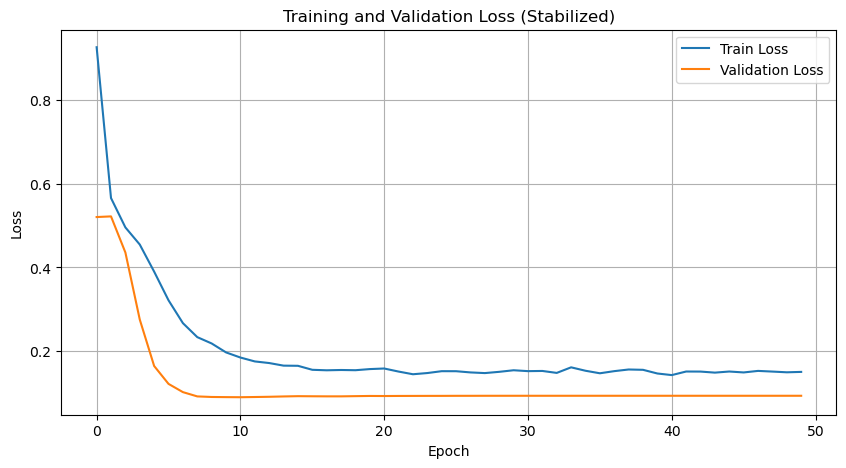

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1. Enhanced MLP Model with Dropout and LayerNorm

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),  # Added for stability
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(input_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(input_dim, 3)
        )

    def forward(self, x):
        return self.layers(x)

# 2. Initialize with Better Practices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Added L2 regularization
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Learning rate scheduler

# 3. Enhanced Training Loop with Stabilization
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for signals, labels in train_loader:
        signals, labels = signals.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for signals, labels in val_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate metrics
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")
    print("-" * 50)

# 4. Comprehensive Test Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for signals, labels in loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Load best model
# model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_labels, test_preds = evaluate_model(model, test_loader)

# Calculate metrics
test_acc = accuracy_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)
misclassified = 1 - test_acc

print("\nFinal Test Evaluation (on 15% held-out set):")
print(f"Accuracy: {test_acc:.2%}")
print(f"Misclassification Rate: {misclassified:.2%}")
print("\nConfusion Matrix:")
print(cm)

# 5. Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Stabilized)')
plt.legend()
plt.grid(True)
plt.show()

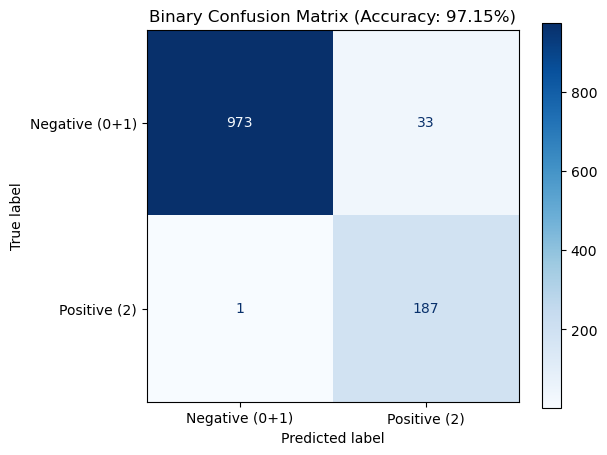


Evaluating on excluded replicate samples:
Binary Accuracy on excluded data: 99.17%


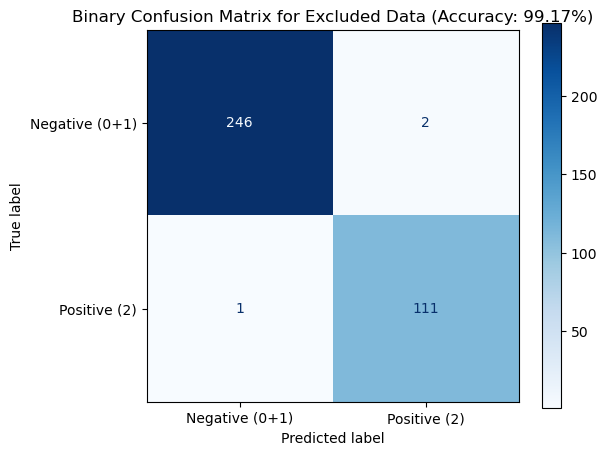

In [ ]:
# Confusion Matrix Visualization with merged classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

def merge_classes(labels, preds):
    """Merge classes 0 and 1 into negative (0), keep class 2 as positive (1)"""
    # Convert to numpy arrays
    labels = np.array(labels)
    preds = np.array(preds)

    # Merge classes
    labels_merged = np.where(labels == 2, 1, 0)
    preds_merged = np.where(preds == 2, 1, 0)

    return labels_merged, preds_merged

# Evaluate on test set
test_labels, test_preds = evaluate_model(model, test_loader)
test_acc = accuracy_score(test_labels, test_preds)

# Merge classes for binary classification
test_labels_merged, test_preds_merged = merge_classes(test_labels, test_preds)
merged_acc = accuracy_score(test_labels_merged, test_preds_merged)

# Create enhanced confusion matrix for binary case
cm_binary = confusion_matrix(test_labels_merged, test_preds_merged)
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary,
                                   display_labels=['Negative (0+1)', 'Positive (2)'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_binary.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Binary Confusion Matrix (Accuracy: {merged_acc:.2%})')
plt.grid(False)
plt.show()


# Test on excluded data from Step 3
print("\nEvaluating on excluded replicate samples:")

# Prepare excluded data
X_excluded = excluded_raw_df.iloc[:, 1:].values.astype(np.float32)
y_excluded = excluded_meta_df['final'].values

# Create dataset and loader
excluded_dataset = SignalDataset(X_excluded, y_excluded, scaler=scaler)
excluded_loader = DataLoader(excluded_dataset, batch_size=batch_size)

# Evaluate
excluded_labels, excluded_preds = evaluate_model(model, excluded_loader)
excluded_acc = accuracy_score(excluded_labels, excluded_preds)

# Merge classes for binary classification
excluded_labels_merged, excluded_preds_merged = merge_classes(excluded_labels, excluded_preds)
excluded_merged_acc = accuracy_score(excluded_labels_merged, excluded_preds_merged)

# Print results
print(f"Binary Accuracy on excluded data: {excluded_merged_acc:.2%}")
excluded_cm_binary = confusion_matrix(excluded_labels_merged, excluded_preds_merged)
disp_excluded_binary = ConfusionMatrixDisplay(confusion_matrix=excluded_cm_binary,
                                            display_labels=['Negative (0+1)', 'Positive (2)'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_excluded_binary.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Binary Confusion Matrix for Excluded Data (Accuracy: {excluded_merged_acc:.2%})')
plt.grid(False)
plt.show()


In [ ]:
excluded_raw_df.to_csv('excluded_raw_data.csv', index=False)


Evaluating on excluded replicate groups:

Per-group performance:
104G (24 samples): Actual positives=15, Predicted positives=15
121G (32 samples): Actual positives=7, Predicted positives=9
----------------------MISMATCH-----------------------
14G (24 samples): Actual positives=2, Predicted positives=2
152G (16 samples): Actual positives=5, Predicted positives=5
157G (16 samples): Actual positives=7, Predicted positives=7
158G (16 samples): Actual positives=6, Predicted positives=6
205G (16 samples): Actual positives=7, Predicted positives=7
206G (16 samples): Actual positives=5, Predicted positives=5
212G (16 samples): Actual positives=4, Predicted positives=4
217G (16 samples): Actual positives=5, Predicted positives=5
267G (16 samples): Actual positives=5, Predicted positives=5
319G (16 samples): Actual positives=7, Predicted positives=7
321G (16 samples): Actual positives=4, Predicted positives=4
325G (16 samples): Actual positives=4, Predicted positives=3
----------------------MIS

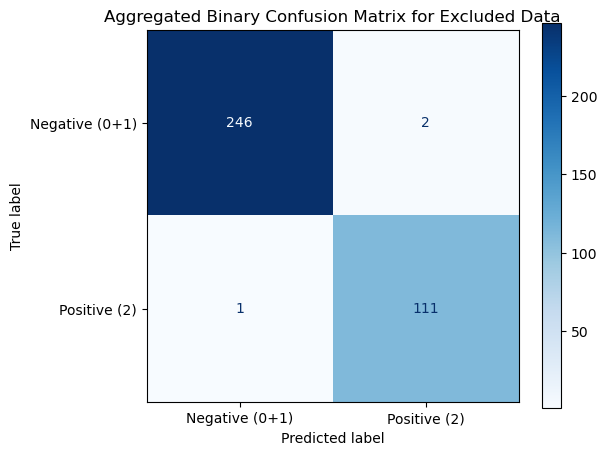

In [ ]:
import re

print("\nEvaluating on excluded replicate groups:")


# Reset indices so they're sequential (0, 1, 2,...)
excluded_raw_df = excluded_raw_df.reset_index(drop=True)
excluded_meta_df = excluded_meta_df.reset_index(drop=True)


# Extract sample IDs and parse base groups
sample_ids = excluded_raw_df.iloc[:, 0].tolist()

def get_base_group(sample_id):
    # Extract the core sample ID (digits + single letter)
    match = re.match(r"^(\d+[A-Za-z])", sample_id)
    if match:
        return match.group(1)  # Returns just the base (e.g., "104G")
    return sample_id  # fallback

base_groups = [get_base_group(s) for s in sample_ids]

# Create grouping structure
group_df = pd.DataFrame({
    'base_group': base_groups,
    'index': excluded_raw_df.index
})
groups = group_df.groupby('base_group')['index'].apply(list).to_dict()


# Initialize collectors
all_excluded_labels_merged = []
all_excluded_preds_merged = []
group_results = []

# Evaluate each replicate group individually
for group_name, indices in groups.items():
    # Extract group data
    X_group = X_excluded[indices]
    y_group = y_excluded[indices]

    # Create dataset and loader (using same scaler)
    group_dataset = SignalDataset(X_group, y_group, scaler=scaler)
    group_loader = DataLoader(group_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate model
    group_labels, group_preds = evaluate_model(model, group_loader)
    group_labels_merged, group_preds_merged = merge_classes(group_labels, group_preds)

    # Calculate positive counts
    n_positive = sum(group_labels_merged)
    n_pred_positive = sum(group_preds_merged)

    # Store results
    group_results.append({
        'group': group_name,
        'n_samples': len(indices),
        'n_positive': n_positive,
        'n_pred_positive': n_pred_positive
    })

    # Aggregate for overall metrics
    all_excluded_labels_merged.extend(group_labels_merged)
    all_excluded_preds_merged.extend(group_preds_merged)

# Calculate overall positive counts
total_positive = sum(all_excluded_labels_merged)
total_pred_positive = sum(all_excluded_preds_merged)

# Print detailed group results
print("\nPer-group performance:")
for res in group_results:
    print(f"{res['group']} ({res['n_samples']} samples): "
          f"Actual positives={res['n_positive']}, Predicted positives={res['n_pred_positive']}")
    if(res['n_pred_positive'] != res['n_positive']):
        print("----------------------MISMATCH-----------------------")

# Print summary statistics
print(f"\nTotal actual positives across all groups: {total_positive}")
print(f"Total predicted positives across all groups: {total_pred_positive}")

# Plot aggregated confusion matrix
excluded_cm_binary = confusion_matrix(all_excluded_labels_merged, all_excluded_preds_merged)
disp_excluded_binary = ConfusionMatrixDisplay(confusion_matrix=excluded_cm_binary,
                                            display_labels=['Negative (0+1)', 'Positive (2)'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_excluded_binary.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Aggregated Binary Confusion Matrix for Excluded Data')
plt.grid(False)
plt.show()

In [ ]:
## STEP 3 Comments:

# Looking at my results on the replicate dataset, there were 2 false positives, and one false negative. Therefore, my model is likely to classify a healthy as infected instead of vice-versa
# Its implication can be drastic espetially with un-needed culling of deer.

# My exclusion of replicates dataset wasn't accurate for all replicates. All of my results match the human annotations except for the following cases
# - 92G, and 104G due to incorrect exclusion of replicates
# - 121G and 325G dues to model inaccuracy (off by 2 more positive in 121G and 1 less positive in 325G)